# EGS master catalogue
## Preparation of Hyper Suprime-Cam Subaru Strategic Program Catalogues (HSC-SSP) wide data

This catalogue comes from `dmu0_HSC`. We only have n921 and n816 photometry on the ultradeep field.

In the catalogue, we keep:

- The `object_id` as unique object identifier;
- The position;
- The g, r, i, z, y aperture magnitude in 2” that we aperture correct;
- The g, r, i, z, y kron fluxes and magnitudes.
- The extended flag that we convert to a stellariy.

We don't know when the maps have been observed. We will use the year of the reference paper.

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))
import datetime
print("This notebook was executed on: \n{}".format(datetime.datetime.now()))

This notebook was run with herschelhelp_internal version: 
0246c5d (Thu Jan 25 17:01:47 2018 +0000) [with local modifications]
This notebook was executed on: 
2018-02-07 19:31:20.726269


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))
plt.style.use('ggplot')

from collections import OrderedDict
import os

from astropy import units as u
from astropy import visualization as vis
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np

from herschelhelp_internal.flagging import  gaia_flag_column
from herschelhelp_internal.masterlist import nb_astcor_diag_plot, nb_plot_mag_ap_evol, \
    nb_plot_mag_vs_apcor, remove_duplicates
from herschelhelp_internal.utils import astrometric_correction, mag_to_flux, aperture_correction

In [3]:
OUT_DIR =  os.environ.get('TMP_DIR', "./data_tmp")
try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

RA_COL = "hsc_ra"
DEC_COL = "hsc_dec"

In [4]:
# Pritine HSC catalogue
orig_hsc = Table.read("../../dmu0/dmu0_HSC/data/HSC-PDR1_wide_EGS_v2.fits")

## I - Aperture correction

To compute aperture correction we need to dertermine two parametres: the target aperture and the range of magnitudes for the stars that will be used to compute the correction.

**Target aperture**: To determine the target aperture, we simulate a curve of growth using the provided apertures and draw two figures:

- The evolution of the magnitudes of the objects by plotting on the same plot aperture number vs the mean magnitude.
- The mean gain (loss when negative) of magnitude is each aperture compared to the previous (except for the first of course).

As target aperture, we should use the smallest (i.e. less noisy) aperture for which most of the flux is captures.

**Magnitude range**: To know what limits in aperture to use when doing the aperture correction, we plot for each magnitude bin the correction that is computed and its RMS. We should then use the wide limits (to use more stars) where the correction is stable and with few dispersion.

In [5]:
bands = ["g", "r", "i", "z", "y"]
apertures = ["10", "15", "20", "30",  "57", "84", "118", "168"] #Removed "40" and "235" because they lack errors

magnitudes = {}
magnitude_errors ={}
stellarities = {}

for band in bands:
    magnitudes[band] = np.array(
        [orig_hsc["{}mag_aperture{}".format(band, aperture)] for aperture in apertures]
    )
    magnitude_errors[band] = np.array(
        [orig_hsc["{}mag_aperture{}_err".format(band, aperture)] for aperture in apertures]
    )
    stellarities[band] = 1 - np.array(orig_hsc["{}classification_extendedness".format(band)])
    
    # Some sources have an infinite magnitude
    mask = np.isinf(magnitudes[band])
    magnitudes[band][mask] = np.nan
    magnitude_errors[band][mask] = np.nan
    
mag_corr = {}

### I.a - g band

/opt/herschelhelp_internal/herschelhelp_internal/masterlist.py:850: RuntimeWarning: invalid value encountered in greater
  mags = magnitudes[:, stellarity > stel_threshold].copy()


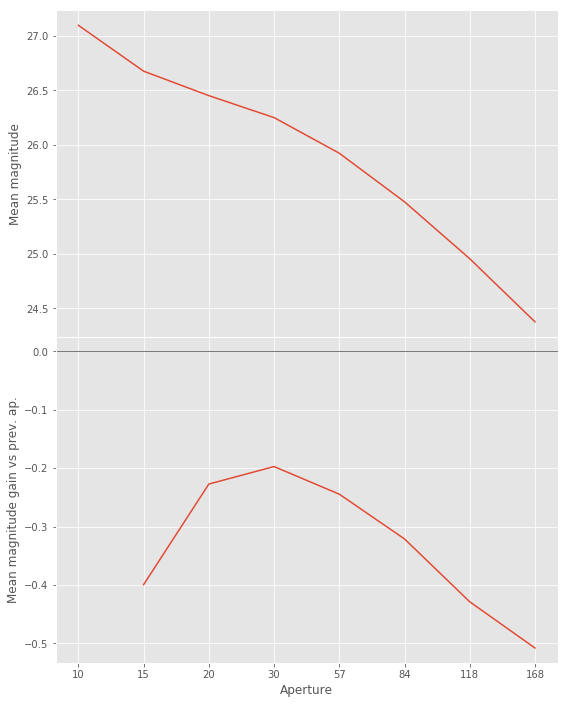

In [6]:
nb_plot_mag_ap_evol(magnitudes['g'], stellarities['g'], labels=apertures)

We will use aperture 57 as target.

/opt/herschelhelp_internal/herschelhelp_internal/masterlist.py:903: RuntimeWarning: invalid value encountered in greater
  mask = stellarity > .9
/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:1096: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)
/opt/herschelhelp_internal/herschelhelp_internal/utils.py:129: RuntimeWarning: invalid value encountered in greater
  mask &= (stellarity > 0.9)
/opt/herschelhelp_internal/herschelhelp_internal/utils.py:131: RuntimeWarning: invalid value encountered in greater_equal
  mask &= (mag >= mag_min)
/opt/herschelhelp_internal/herschelhelp_internal/utils.py:133: RuntimeWarning: invalid value encountered in less_equal
  mask &= (mag <= mag_max)


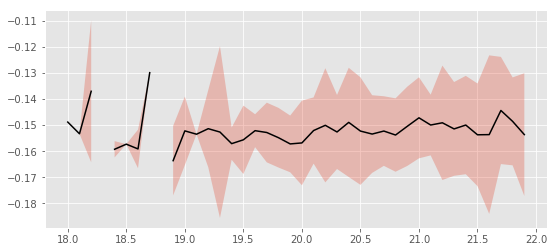

In [7]:
nb_plot_mag_vs_apcor(orig_hsc['gmag_aperture20'], orig_hsc['gmag_aperture57'], stellarities['g'])

We will use magnitudes between 18.5 and 20.8

In [8]:
# Aperture correction
mag_corr['g'], num, std = aperture_correction(
    orig_hsc['gmag_aperture20'], orig_hsc['gmag_aperture57'], 
    stellarities['g'],
    mag_min=18.5, mag_max=20.8)
print("Aperture correction for g band:")
print("Correction: {}".format(mag_corr['g']))
print("Number of source used: {}".format(num))
print("RMS: {}".format(std))

Aperture correction for g band:
Correction: -0.1536693572998047
Number of source used: 477
RMS: 0.013336935836438763


/opt/herschelhelp_internal/herschelhelp_internal/utils.py:129: RuntimeWarning: invalid value encountered in greater
  mask &= (stellarity > 0.9)
/opt/herschelhelp_internal/herschelhelp_internal/utils.py:131: RuntimeWarning: invalid value encountered in greater_equal
  mask &= (mag >= mag_min)
/opt/herschelhelp_internal/herschelhelp_internal/utils.py:133: RuntimeWarning: invalid value encountered in less_equal
  mask &= (mag <= mag_max)


### I.b - r band

/opt/herschelhelp_internal/herschelhelp_internal/masterlist.py:850: RuntimeWarning: invalid value encountered in greater
  mags = magnitudes[:, stellarity > stel_threshold].copy()


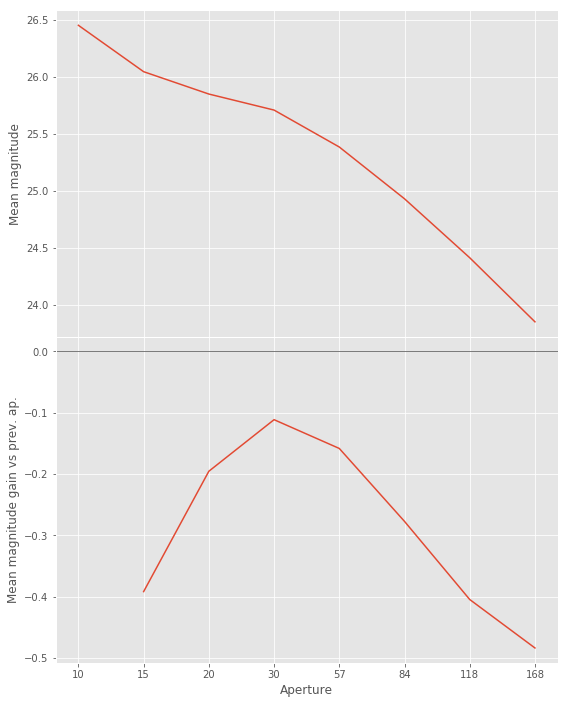

In [9]:
nb_plot_mag_ap_evol(magnitudes['r'], stellarities['r'], labels=apertures)

We will use aperture 57 as target.

/opt/herschelhelp_internal/herschelhelp_internal/masterlist.py:903: RuntimeWarning: invalid value encountered in greater
  mask = stellarity > .9
/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:1096: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)
/opt/herschelhelp_internal/herschelhelp_internal/utils.py:129: RuntimeWarning: invalid value encountered in greater
  mask &= (stellarity > 0.9)
/opt/herschelhelp_internal/herschelhelp_internal/utils.py:131: RuntimeWarning: invalid value encountered in greater_equal
  mask &= (mag >= mag_min)
/opt/herschelhelp_internal/herschelhelp_internal/utils.py:133: RuntimeWarning: invalid value encountered in less_equal
  mask &= (mag <= mag_max)


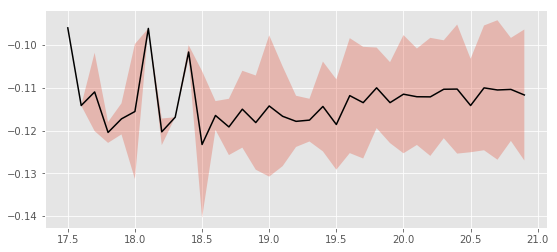

In [10]:
nb_plot_mag_vs_apcor(orig_hsc['rmag_aperture20'], orig_hsc['rmag_aperture57'], stellarities['r'])

We use magnitudes between 19.5 and 20.5.

In [11]:
# Aperture correction
mag_corr['r'], num, std = aperture_correction(
    orig_hsc['rmag_aperture20'], orig_hsc['rmag_aperture57'], 
    stellarities['r'],
    mag_min=19.5, mag_max=20.5)
print("Aperture correction for r band:")
print("Correction: {}".format(mag_corr['r']))
print("Number of source used: {}".format(num))
print("RMS: {}".format(std))

Aperture correction for r band:
Correction: -0.11204338073730469
Number of source used: 606
RMS: 0.012112590040337011


/opt/herschelhelp_internal/herschelhelp_internal/utils.py:129: RuntimeWarning: invalid value encountered in greater
  mask &= (stellarity > 0.9)
/opt/herschelhelp_internal/herschelhelp_internal/utils.py:131: RuntimeWarning: invalid value encountered in greater_equal
  mask &= (mag >= mag_min)
/opt/herschelhelp_internal/herschelhelp_internal/utils.py:133: RuntimeWarning: invalid value encountered in less_equal
  mask &= (mag <= mag_max)


### I.c - i band

/opt/herschelhelp_internal/herschelhelp_internal/masterlist.py:850: RuntimeWarning: invalid value encountered in greater
  mags = magnitudes[:, stellarity > stel_threshold].copy()


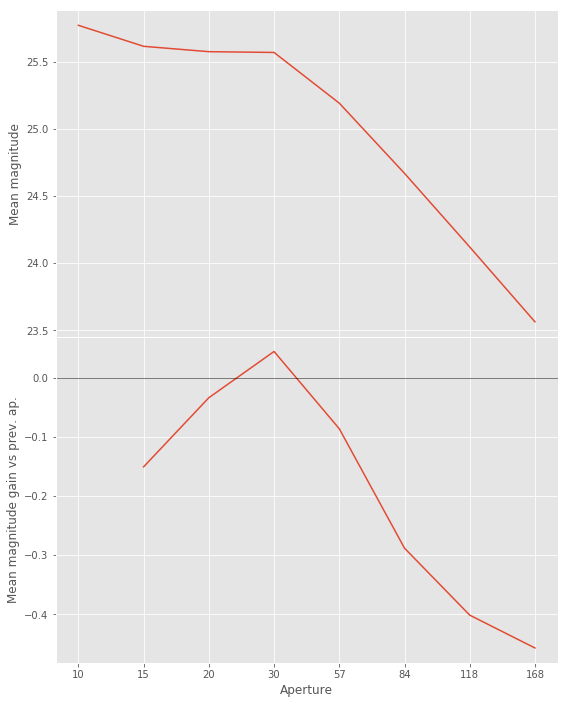

In [12]:
nb_plot_mag_ap_evol(magnitudes['i'], stellarities['i'], labels=apertures)

We will use aperture 57 as target.

/opt/herschelhelp_internal/herschelhelp_internal/masterlist.py:903: RuntimeWarning: invalid value encountered in greater
  mask = stellarity > .9
/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:1096: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)
/opt/herschelhelp_internal/herschelhelp_internal/utils.py:129: RuntimeWarning: invalid value encountered in greater
  mask &= (stellarity > 0.9)
/opt/herschelhelp_internal/herschelhelp_internal/utils.py:131: RuntimeWarning: invalid value encountered in greater_equal
  mask &= (mag >= mag_min)
/opt/herschelhelp_internal/herschelhelp_internal/utils.py:133: RuntimeWarning: invalid value encountered in less_equal
  mask &= (mag <= mag_max)


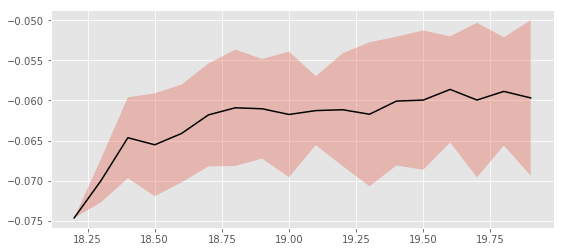

In [13]:
nb_plot_mag_vs_apcor(orig_hsc['imag_aperture20'], orig_hsc['imag_aperture57'], stellarities['i'])

We use magnitudes between 18.5 and 19.8.

In [14]:
# Aperture correction
mag_corr['i'], num, std = aperture_correction(
    orig_hsc['imag_aperture20'], orig_hsc['imag_aperture57'], 
    stellarities['i'],
    mag_min=18.5, mag_max=19.8)
print("Aperture correction for i band:")
print("Correction: {}".format(mag_corr['i']))
print("Number of source used: {}".format(num))
print("RMS: {}".format(std))

Aperture correction for i band:
Correction: -0.06093025207519531
Number of source used: 831
RMS: 0.007157356612245586


/opt/herschelhelp_internal/herschelhelp_internal/utils.py:129: RuntimeWarning: invalid value encountered in greater
  mask &= (stellarity > 0.9)
/opt/herschelhelp_internal/herschelhelp_internal/utils.py:131: RuntimeWarning: invalid value encountered in greater_equal
  mask &= (mag >= mag_min)
/opt/herschelhelp_internal/herschelhelp_internal/utils.py:133: RuntimeWarning: invalid value encountered in less_equal
  mask &= (mag <= mag_max)


### I.d - z band

/opt/herschelhelp_internal/herschelhelp_internal/masterlist.py:850: RuntimeWarning: invalid value encountered in greater
  mags = magnitudes[:, stellarity > stel_threshold].copy()


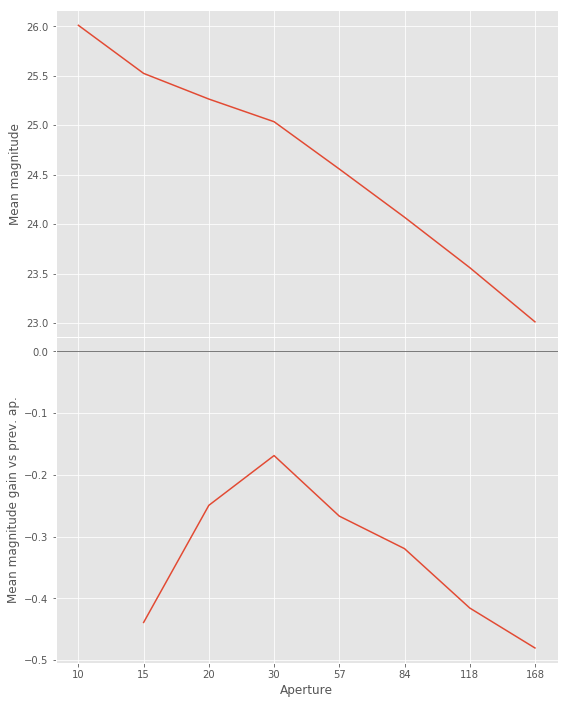

In [15]:
nb_plot_mag_ap_evol(magnitudes['z'], stellarities['z'], labels=apertures)

We will use aperture 57 as target.

/opt/herschelhelp_internal/herschelhelp_internal/masterlist.py:903: RuntimeWarning: invalid value encountered in greater
  mask = stellarity > .9
/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:1096: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)
/opt/herschelhelp_internal/herschelhelp_internal/utils.py:129: RuntimeWarning: invalid value encountered in greater
  mask &= (stellarity > 0.9)
/opt/herschelhelp_internal/herschelhelp_internal/utils.py:131: RuntimeWarning: invalid value encountered in greater_equal
  mask &= (mag >= mag_min)
/opt/herschelhelp_internal/herschelhelp_internal/utils.py:133: RuntimeWarning: invalid value encountered in less_equal
  mask &= (mag <= mag_max)


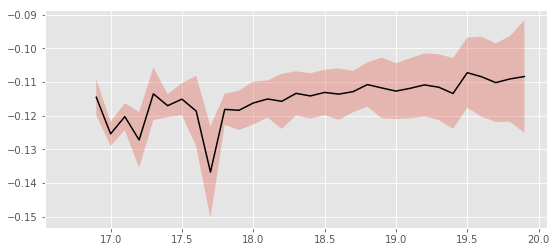

In [16]:
nb_plot_mag_vs_apcor(orig_hsc['zmag_aperture20'], orig_hsc['zmag_aperture57'], stellarities['z'])

We use magnitudes between 17.5 and 18.8.

In [17]:
# Aperture correction
mag_corr['z'], num, std = aperture_correction(
    orig_hsc['zmag_aperture20'], orig_hsc['zmag_aperture57'], 
    stellarities['z'],
    mag_min=17.5, mag_max=18.8)
print("Aperture correction for z band:")
print("Correction: {}".format(mag_corr['z']))
print("Number of source used: {}".format(num))
print("RMS: {}".format(std))

Aperture correction for z band:
Correction: -0.1141510009765625
Number of source used: 333
RMS: 0.00688200402082919


/opt/herschelhelp_internal/herschelhelp_internal/utils.py:129: RuntimeWarning: invalid value encountered in greater
  mask &= (stellarity > 0.9)
/opt/herschelhelp_internal/herschelhelp_internal/utils.py:131: RuntimeWarning: invalid value encountered in greater_equal
  mask &= (mag >= mag_min)
/opt/herschelhelp_internal/herschelhelp_internal/utils.py:133: RuntimeWarning: invalid value encountered in less_equal
  mask &= (mag <= mag_max)


### I.e - y band

/opt/herschelhelp_internal/herschelhelp_internal/masterlist.py:850: RuntimeWarning: invalid value encountered in greater
  mags = magnitudes[:, stellarity > stel_threshold].copy()


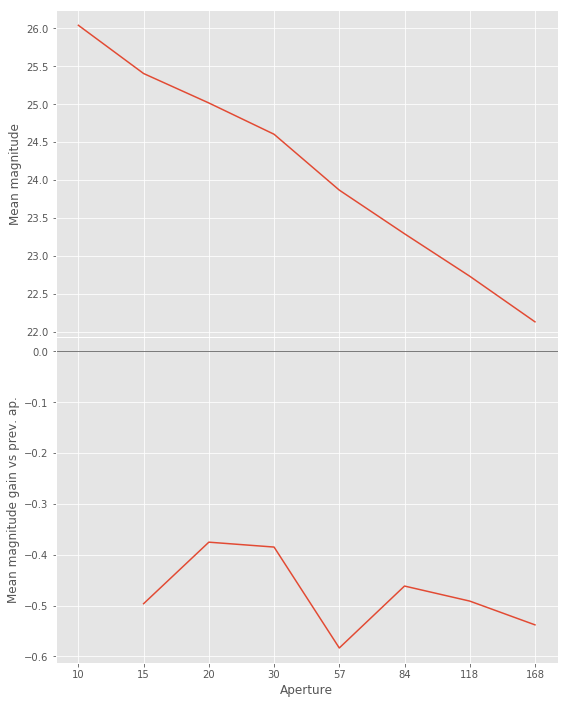

In [18]:
nb_plot_mag_ap_evol(magnitudes['y'], stellarities['y'], labels=apertures)

We will use aperture 57 as target.

/opt/herschelhelp_internal/herschelhelp_internal/masterlist.py:903: RuntimeWarning: invalid value encountered in greater
  mask = stellarity > .9
/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:1096: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)
/opt/herschelhelp_internal/herschelhelp_internal/utils.py:129: RuntimeWarning: invalid value encountered in greater
  mask &= (stellarity > 0.9)
/opt/herschelhelp_internal/herschelhelp_internal/utils.py:131: RuntimeWarning: invalid value encountered in greater_equal
  mask &= (mag >= mag_min)
/opt/herschelhelp_internal/herschelhelp_internal/utils.py:133: RuntimeWarning: invalid value encountered in less_equal
  mask &= (mag <= mag_max)


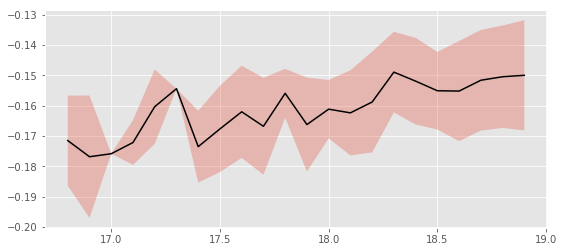

In [19]:
nb_plot_mag_vs_apcor(orig_hsc['ymag_aperture20'], orig_hsc['ymag_aperture57'], stellarities['y'])

We use magnitudes between 17.6 and 18.7.

In [20]:
# Aperture correction
mag_corr['y'], num, std = aperture_correction(
    orig_hsc['ymag_aperture20'], orig_hsc['ymag_aperture57'], 
    stellarities['y'],
    mag_min=17.6, mag_max=18.7)
print("Aperture correction for y band:")
print("Correction: {}".format(mag_corr['y']))
print("Number of source used: {}".format(num))
print("RMS: {}".format(std))

Aperture correction for y band:
Correction: -0.15555763244628906
Number of source used: 334
RMS: 0.015017790515423833


/opt/herschelhelp_internal/herschelhelp_internal/utils.py:129: RuntimeWarning: invalid value encountered in greater
  mask &= (stellarity > 0.9)
/opt/herschelhelp_internal/herschelhelp_internal/utils.py:131: RuntimeWarning: invalid value encountered in greater_equal
  mask &= (mag >= mag_min)
/opt/herschelhelp_internal/herschelhelp_internal/utils.py:133: RuntimeWarning: invalid value encountered in less_equal
  mask &= (mag <= mag_max)


## II - Stellarity

HSC does not provide a 0 to 1 stellarity value but a 0/1 extended flag in each band. We are using the same method as UKIDSS ([cf this page](http://wsa.roe.ac.uk/www/gloss_p.html#dxssource_pstar)) to compute a stellarity based on the class in each band:

\begin{equation*}
P(star) = \frac{ \prod_{i} P(star)_i }{ \prod_{i} P(star)_i + \prod_{i} P(galaxy)_i }
\end{equation*}

where $i$ is the band, and with using the same probabilities as UKDISS:

| HSC flag | UKIDSS flag | Meaning         | P(star) | P(galaxy) | P(noise) | P(saturated) |
|:--------:|:-----------:|:----------------|--------:|----------:|---------:|-------------:|
|          |      -9     | Saturated       |     0.0 |       0.0 |      5.0 |         95.0 |
|          |      -3     | Probable galaxy |    25.0 |      70.0 |      5.0 |          0.0 |
|          |      -2     | Probable star   |    70.0 |      25.0 |      5.0 |          0.0 |
|     0    |      -1     | Star            |    90.0 |       5.0 |      5.0 |          0.0 |
|          |      0      | Noise           |     5.0 |       5.0 |     90.0 |          0.0 |
|     1    |      +1     | Galaxy          |     5.0 |      90.0 |      5.0 |          0.0 |

In [21]:
# We are creating an array containing the extended flag in all band.
# Some sources have no flag in some band, there will be NaN in the array.
hsc_ext_flag = np.array([
    orig_hsc[colname] for colname in 
    ['gclassification_extendedness',
     'rclassification_extendedness',
     'iclassification_extendedness',
     'zclassification_extendedness',
     'yclassification_extendedness']
])

In [22]:
hsc_pstar = 0.9 * (hsc_ext_flag == 0) + 0.05 * (hsc_ext_flag == 1)
hsc_pgal = 0.05 * (hsc_ext_flag == 0) + 0.9 * (hsc_ext_flag == 1)

# We put back the NaN values
hsc_pstar[np.isnan(hsc_ext_flag)] = np.nan
hsc_pgal[np.isnan(hsc_ext_flag)] = np.nan

In [23]:
stellarity = np.nanprod(hsc_pstar, axis=0) / np.nansum(
    [np.nanprod(hsc_pgal, axis=0), np.nanprod(hsc_pstar, axis=0)], axis=0)

stellarity = np.round(stellarity, 3)

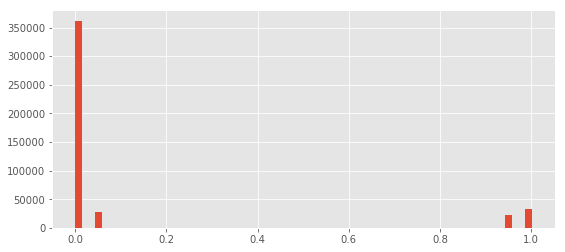

In [24]:
vis.hist(stellarity, bins='scott');

In [25]:
orig_hsc.add_column(Column(data=stellarity, name="stellarity"))

## II - Column selection

In [26]:
imported_columns = OrderedDict({
        "object_id": "hsc_id",
        "ra": "hsc_ra",
        "dec": "hsc_dec",
        "gmag_aperture20": "m_ap_suprime_g",
        "gmag_aperture20_err": "merr_ap_suprime_g",
        "gmag_kron": "m_suprime_g",
        "gmag_kron_err": "merr_suprime_g",
        "rmag_aperture20": "m_ap_suprime_r",
        "rmag_aperture20_err": "merr_ap_suprime_r",
        "rmag_kron": "m_suprime_r",
        "rmag_kron_err": "merr_suprime_r",
        "imag_aperture20": "m_ap_suprime_i",
        "imag_aperture20_err": "merr_ap_suprime_i",
        "imag_kron": "m_suprime_i",
        "imag_kron_err": "merr_suprime_i",
        "zmag_aperture20": "m_ap_suprime_z",
        "zmag_aperture20_err": "merr_ap_suprime_z",
        "zmag_kron": "m_suprime_z",
        "zmag_kron_err": "merr_suprime_z",
        "ymag_aperture20": "m_ap_suprime_y",
        "ymag_aperture20_err": "merr_ap_suprime_y",
        "ymag_kron": "m_suprime_y",
        "ymag_kron_err": "merr_suprime_y",
        "stellarity": "hsc_stellarity"
    })


catalogue = orig_hsc[list(imported_columns)]
for column in imported_columns:
    catalogue[column].name = imported_columns[column]

epoch = 2017

# Clean table metadata
catalogue.meta = None

In [27]:
# Aperture correction
for band in bands:
    catalogue["m_ap_suprime_{}".format(band)] += mag_corr[band]

In [28]:
# Adding flux and band-flag columns
for col in catalogue.colnames:
    if col.startswith('m_'):
        
        errcol = "merr{}".format(col[1:])
        
        #Some inf and 99. mags
        mask = (catalogue[col] > 90.) | (catalogue[errcol] > 90.)
        catalogue[col][mask] = np.nan
        catalogue[errcol][mask] = np.nan
        
        flux, error = mag_to_flux(np.array(catalogue[col]), np.array(catalogue[errcol]))
        
        # Fluxes are added in µJy
        catalogue.add_column(Column(flux * 1.e6, name="f{}".format(col[1:])))
        catalogue.add_column(Column(error * 1.e6, name="f{}".format(errcol[1:])))
        
        # Band-flag column
        if 'ap' not in col:
            catalogue.add_column(Column(np.zeros(len(catalogue), dtype=bool), name="flag{}".format(col[1:])))
        
# TODO: Set to True the flag columns for fluxes that should not be used for SED fitting.

In [29]:
catalogue[:10].show_in_notebook()

idx,hsc_id,hsc_ra,hsc_dec,m_ap_suprime_g,merr_ap_suprime_g,m_suprime_g,merr_suprime_g,m_ap_suprime_r,merr_ap_suprime_r,m_suprime_r,merr_suprime_r,m_ap_suprime_i,merr_ap_suprime_i,m_suprime_i,merr_suprime_i,m_ap_suprime_z,merr_ap_suprime_z,m_suprime_z,merr_suprime_z,m_ap_suprime_y,merr_ap_suprime_y,m_suprime_y,merr_suprime_y,hsc_stellarity,f_ap_suprime_g,ferr_ap_suprime_g,f_suprime_g,ferr_suprime_g,flag_suprime_g,f_ap_suprime_r,ferr_ap_suprime_r,f_suprime_r,ferr_suprime_r,flag_suprime_r,f_ap_suprime_i,ferr_ap_suprime_i,f_suprime_i,ferr_suprime_i,flag_suprime_i,f_ap_suprime_z,ferr_ap_suprime_z,f_suprime_z,ferr_suprime_z,flag_suprime_z,f_ap_suprime_y,ferr_ap_suprime_y,f_suprime_y,ferr_suprime_y,flag_suprime_y
0,73979570428051653,213.865080623,51.7835175679,24.1435,0.0431081,24.048,0.058657,23.4251,0.0409119,23.2774,0.0549201,22.8293,0.0197804,22.6531,0.0274015,22.1764,0.0274187,22.0038,0.0347522,21.865,0.0468892,21.797,0.0664418,0.0,0.799098,0.0317274,0.872586,0.0471415,False,1.54874,0.0583585,1.77436,0.0897529,False,2.68089,0.0488415,3.1532,0.0795795,False,4.89151,0.123528,5.73443,0.183548,False,6.51606,0.281406,6.93715,0.42452,False
1,73979570428051665,213.866851318,51.7835728591,25.2779,0.120501,25.5666,0.320401,24.9951,0.175656,24.9199,0.334826,24.4824,0.0906785,24.268,0.162931,24.1161,0.159562,23.508,0.184597,23.4128,0.198055,22.825,0.236185,0.0,0.281074,0.0311952,0.215448,0.0635787,False,0.364721,0.0590067,0.390862,0.120536,False,0.584838,0.0488445,0.712496,0.10692,False,0.819487,0.120433,1.43482,0.243948,False,1.56631,0.285719,2.69144,0.585482,False
2,73979570428051673,213.821274042,51.7842495445,22.6312,0.0116385,22.7621,0.0109097,21.4022,0.00685668,21.4833,0.00642837,20.1716,0.00190966,20.1772,0.00179106,19.6685,0.00289955,19.7747,0.00275223,19.455,0.00536657,19.5561,0.00500278,1.0,3.21747,0.0344895,2.85217,0.0286592,False,9.97993,0.0630256,9.26144,0.0548346,False,31.0008,0.0545261,30.8392,0.0508731,False,49.2727,0.131587,44.6808,0.113261,False,59.9801,0.296469,54.6452,0.25179,False
3,73979570428051683,213.83868702,51.7841777919,25.9809,0.234717,26.4355,1.19998,26.0994,0.482324,25.0592,0.64616,25.8374,0.328618,24.1897,0.256116,25.5573,0.605595,24.0929,0.539749,24.7156,0.651893,nan,nan,0.0,0.147115,0.0318037,0.0967827,0.106966,False,0.131904,0.0585965,0.343812,0.204615,False,0.167891,0.0508151,0.765815,0.180649,False,0.217314,0.121212,0.837216,0.416203,False,0.471799,0.283276,nan,nan,False
4,73979570428051685,213.892035196,51.7837674967,26.6866,0.444565,nan,nan,25.9175,0.411584,25.0206,0.783803,25.1725,0.170279,25.6091,1.19289,26.2425,1.11222,24.709,1.19628,nan,nan,nan,nan,0.0,0.0768011,0.031447,nan,nan,False,0.155955,0.0591199,0.356241,0.257173,False,0.309739,0.0485772,0.207191,0.227639,False,0.115616,0.118436,0.474698,0.52303,False,nan,nan,nan,nan,False
5,73979570428051689,213.790051477,51.7847254102,27.7034,1.1964,nan,nan,26.4305,0.668784,27.0851,0.835565,26.4007,0.606879,25.9825,0.290326,25.9863,1.04219,25.9692,0.685569,27.2944,8.46714,27.2312,5.4035,0.053,0.0301042,0.0331726,nan,nan,False,0.097232,0.0598923,0.053204,0.0409449,False,0.0999324,0.0558578,0.146886,0.0392772,False,0.146381,0.14051,0.148697,0.0938919,False,0.043879,0.342192,0.0465074,0.231459,False
6,73979570428051692,213.79885684,51.7848170634,25.6929,0.18485,25.7926,0.183912,25.5663,0.300183,25.6195,0.30063,25.0201,0.146093,25.0125,0.146952,25.0218,0.370539,25.0379,0.353096,nan,nan,nan,nan,0.0,0.191797,0.032654,0.174961,0.0296366,False,0.215508,0.0595832,0.205207,0.0568199,False,0.35641,0.0479572,0.358918,0.0485789,False,0.355856,0.121446,0.350635,0.114031,False,nan,nan,nan,nan,False
7,73979570428051696,213.894779589,51.7839346751,25.7061,0.180304,25.7347,0.215563,25.6442,0.310376,25.7575,0.415212,25.6454,0.263673,25.2704,0.236805,26.6214,1.59041,26.5572,1.75714,25.4404,1.30597,25.4609,1.53691,0.0,0.189485,0.0314671,0.184545,0.0366399,False,0.200586,0.0573408,0.180715,0.0691098,False,0.200382,0.048663,0.283039,0.0617322,False,0.081551,0.119457,0.0865206,

## III - Removal of duplicated sources

We remove duplicated objects from the input catalogues.

In [30]:
SORT_COLS = [
        'merr_ap_suprime_i', 'merr_ap_suprime_r', 'merr_ap_suprime_z',
        'merr_ap_suprime_y', 'merr_ap_suprime_g']
FLAG_NAME = 'hsc_flag_cleaned'

nb_orig_sources = len(catalogue)

catalogue = remove_duplicates(
    catalogue, RA_COL, DEC_COL, 
    sort_col= SORT_COLS,
    flag_name=FLAG_NAME)

nb_sources = len(catalogue)

print("The initial catalogue had {} sources.".format(nb_orig_sources))
print("The cleaned catalogue has {} sources ({} removed).".format(nb_sources, nb_orig_sources - nb_sources))
print("The cleaned catalogue has {} sources flagged as having been cleaned".format(np.sum(catalogue[FLAG_NAME])))

/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:1096: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)


The initial catalogue had 444602 sources.
The cleaned catalogue has 444573 sources (29 removed).
The cleaned catalogue has 29 sources flagged as having been cleaned


## III - Astrometry correction

We match the astrometry to the Gaia one. We limit the Gaia catalogue to sources with a g band flux between the 30th and the 70th percentile. Some quick tests show that this give the lower dispersion in the results.

In [31]:
gaia = Table.read("../../dmu0/dmu0_GAIA/data/GAIA_EGS.fits")
gaia_coords = SkyCoord(gaia['ra'], gaia['dec'])

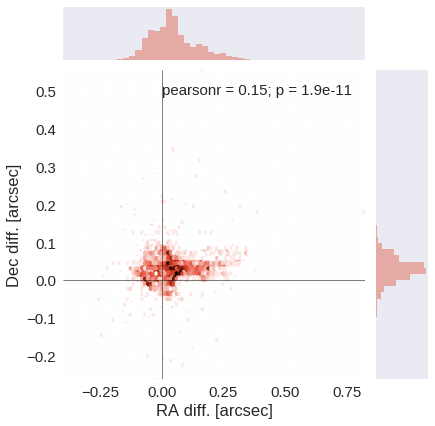

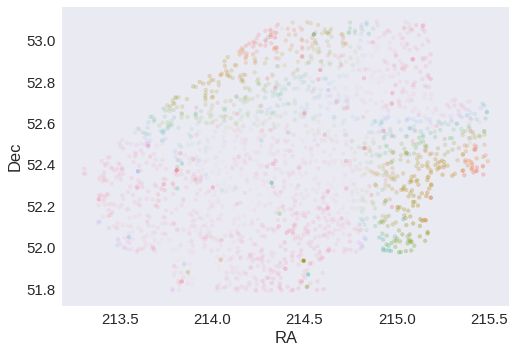

In [32]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

In [33]:
delta_ra, delta_dec =  astrometric_correction(
    SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]),
    gaia_coords
)

print("RA correction: {}".format(delta_ra))
print("Dec correction: {}".format(delta_dec))

RA correction: -0.03406401734764586 arcsec
Dec correction: -0.03037861431209876 arcsec


In [34]:
catalogue[RA_COL] +=  delta_ra.to(u.deg)
catalogue[DEC_COL] += delta_dec.to(u.deg)

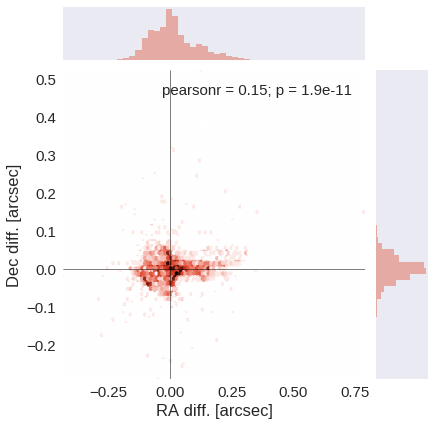

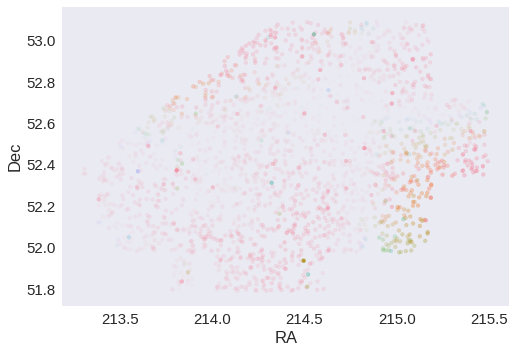

In [35]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

## IV - Flagging Gaia objects

In [36]:
catalogue.add_column(
    gaia_flag_column(SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]), epoch, gaia)
)

In [37]:
GAIA_FLAG_NAME = "hsc_flag_gaia"

catalogue['flag_gaia'].name = GAIA_FLAG_NAME
print("{} sources flagged.".format(np.sum(catalogue[GAIA_FLAG_NAME] > 0)))

2264 sources flagged.


# V - Saving to disk

In [38]:
catalogue.write("{}/HSC.fits".format(OUT_DIR), overwrite=True)